In [1]:
# Initialization of packaging and figure looking in matplotlib
# the tools module contains costum set of functions for GP interpolation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from cobaya.run import run
from cobaya.yaml import yaml_load_file
import seaborn as sns
from getdist import  loadMCSamples, MCSamples
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
import os, sys

colors = ["#003049","#d62828", "#f77f00", "#fcbf49",'#eae2b7']
cpal= sns.color_palette(colors)

plt.rcParams['mathtext.default']= 'regular'
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams["axes.labelpad"]=10   # axes labels distance from tick labels
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
rc('text',usetex=False)           # use LaTex for plot texts plt.rcParams['figure.dpi'] = 100  #  figure dimension in dpi
plt.rcParams['figure.dpi'] = 150


from cobaya.yaml import yaml_load_file

In [3]:
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'../CAMB/'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.5 installed at /data1/renzi/CAMB/camb


In [4]:
pars = camb.set_params(H0=70,ombh2=0.0224,omch2=0.12)

results = camb.get_background(pars)

dL = results.luminosity_distance

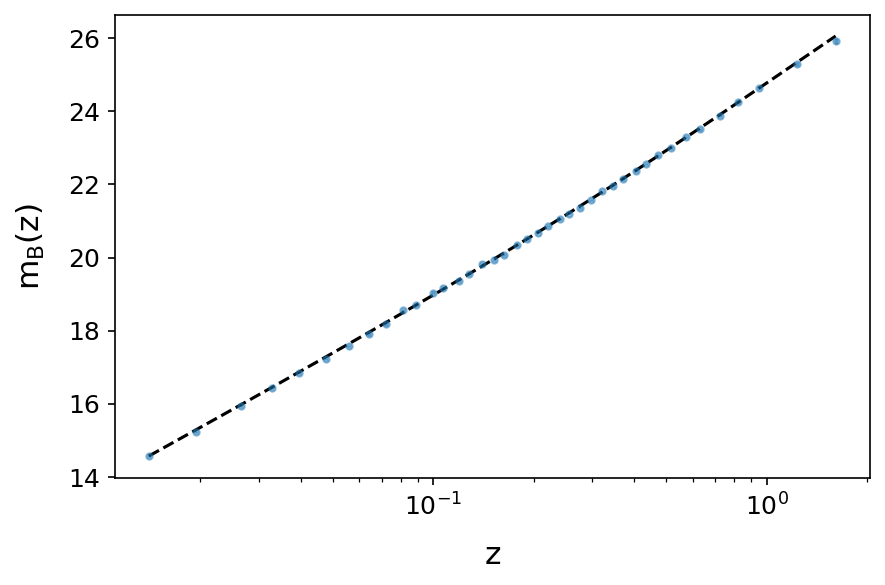

In [17]:
zsn,mb,dmb = np.loadtxt('data/lcparam_DS17f.txt',usecols=(1,4,5),unpack=True)
cov = np.loadtxt('data/sys_DS17f.txt',unpack=True,skiprows=1)

cov = np.reshape(cov,(40,40))


plt.figure()
plt.errorbar(zsn,mb,dmb,fmt='.',alpha=0.5)

plt.plot(zsn,5*np.log10(70*dL(zsn)) -0.7127*5,'--k')
plt.xlabel("$z$")
plt.ylabel("$m_B(z)$")

plt.xscale('log')


plt.tight_layout()


In [71]:
inv_cov = np.linalg.inv(cov) 

def lnlike(_self=None,H0=70):
    comv = _self.provider.get_comoving_radial_distance
    
    res_mag = mb - 5*np.log10(comv(zsn)*(1+zsn))
    
    chi2 = np.dot(res_mag.T,np.dot(inv_cov,res_mag))
                  
    return -0.5*np.sum(chi2)
    

In [72]:
info = {'likelihood': {'my_cl_like': {
        "external": lnlike,
        # Declare required quantities!
        "requires": {'comoving_radial_distance': {'z': zsn}},
        }},
 'params': {'ombh2': {'latex': '\\Omega_\\mathrm{b} h^2',
                      'value': 'lambda omegab, H0: omegab*(H0/100)**2'},
            'omch2': {'latex': '\\Omega_\\mathrm{c} h^2',
                      'value': 'lambda omegam, omegab, H0: '
                               '(omegam-omegab)*(H0/100)**2-(0.06*(3.046/3)**0.75)/94.0708'},
            'omega_de': {'latex': '\\Omega_\\Lambda'},
            'H0': 70,
            'omegab': 0.0495,
            'omegam': {'drop': True,
                       'latex': '\\Omega_\\mathrm{m}',
                       'prior': {'max': 0.4, 'min': 0.2},
                       'proposal': 0.02,
                       'ref': {'dist': 'norm', 'loc': 0.316, 'scale': 0.02}},
            'omegamh2': {'derived': 'lambda omegam, H0: omegam*(H0/100)**2',
                         'latex': '\\Omega_\\mathrm{m} h^2'}
            },
 'sampler': {'mcmc': {'Rminus1_cl_stop': 0.2,
                      'Rminus1_stop': 0.01,
                      'oversample_power': 0.4,
                      'proposal_scale': 1.9,
                      'max_tries':10000,
                      
                     }},
 'theory': {'camb': {'extra_args': {'bbn_predictor': 'PArthENoPE_880.2_standard.dat',
                                    'halofit_version': 'mead',
                                    'lens_potential_accuracy': 1,
                                    
                                    'nnu': 3.046,
                                    'num_massive_neutrinos': 1,
                                    }}},
       
'stop_at_error':True}

In [ ]:
update_info,sampler = run(info)

[CAMB] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
[my_cl_like] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {my_cl_like: 12200.0, camb.transfers: 63.6, camb: 5690.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omegam:0.3161642
[mcmc] Sampling!
[mcmc] Progress @ 2022-04-05 18:04:13 : 1 steps taken, and 0 accepted.
